# Create and Update Mask Demo

Important update the colab link:
[Colab Link](https://colab.research.google.com/github/casangi/astroviper/blob/main/docs/core_tutorials/image_analysis/make_mask.ipynb)

This notebook demonstrates how to create and update mask image using `make_mask` function. The function takes xds images as inputs and returns xds mask image, optionally to a disk file in zarr or CASA image format (using xradio write_image function). Current implementation is focused on PB based mask for deconvolution but could be more generalized in the future to support different use cases. 

---

## API

In [1]:
from astroviper.core.image_analysis.make_mask import make_mask
make_mask?

Signature:
make_mask(
    input_image: xarray.core.dataarray.DataArray,
    threshold: float,
    target_image: xarray.core.dataarray.DataArray = None,
    apply_on_target: bool = False,
    combine_mask: bool = False,
    output_image_name: str = '',
    output_format: str = 'zarr',
)
Docstring:
Create or update mask image

Parameters:
input_image : xarray.DataArray
    Input image name (assume pb image for now)
threshold : float
    PB cutoff with respect to the peak value
target_image : xarray.DataArray
    Target image to the generated mask to be used
    to check dimensions and existing mask
apply_on_target : boolean
    Whether to apply the mask on target_image (default: False)
combine_mask : boolean
    Whether to combine with existing mask in target_image (default: False)
output_image_name : str (optional)
    Output mask image name

Returns:
    xarray.Dataset
    Boolean array stored in the data variable 'MASK' in the xradio image
    if apply_on_target is True, the returned 

---
## Notes

- Input image data are assumed to be in xradio image format
- When data variable MASK0 is detected it assumes the mask data is from a CASA image and reverse True/False definiton (True = good pixels, False = bad) 
- This function is currently limited to create/update PB threshold based mask. Automasking and other types of masking will be supported in the future.
---


## Install AstroVIPER

Skip this cell if you don't want to install the latest version of AstroVIPER.

In [2]:
from importlib.metadata import version
import os

try:
    os.system("pip install --upgrade astroviper")

    import astroviper

    print("Using astroviper version", version("astroviper"))

except ImportError as exc:
    print(f"Could not import astroviper: {exc}")

Using astroviper version 0.0.30


## Import additional modules/functions used in this notebook

In [3]:
from xradio.image import make_empty_sky_image
from astropy.modeling.models import Gaussian2D
from astropy.time import Time
from datetime import datetime, timezone
import dask.array as da
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## Generate input images
Generate xds images for the inputs to `make_mask`. The following function generates ALMA mock-up primary beam or residual images by specifying image_type to 'pb' or 'residual' with specified frequncies and image size. The time and polarization are filled with dummy values. When add_mask=True, a predefined rectangular mask is added to the image (to domonstrate combine_mask=True use case).


In [4]:
def generate_image_xds(phase_center, image_size, cell_size, freqs, image_type, add_mask=False):
    # set polarization to I
    pols = np.array(['I'])
    # set date 2025 10 01 
    t = Time(datetime(2025,10,1,0,0))
    times = np.array([t.mjd])
    # generate image xds 
    new_xds = make_empty_sky_image(phase_center=phase_center, 
                         image_size = image_size, 
                         cell_size = cell_size,
                         frequency_coords = freqs,
                         pol_coords = pols,
                         time_coords = times
                        )
    shape = tuple(new_xds.dims[d] for d in ['time','frequency','polarization','l','m'])
    y = new_xds.l.data
    x = new_xds.m.data
    xv,yv = np.meshgrid(x,y)

    image_data = np.zeros(shape)
    if image_type=="pb":
        # Assume ALMA 12m
        dish_dia = 12.
        # loop over frequencies
        for index, freq in enumerate(freqs):
            sigma = (1.13/2.355)*(2.99792e8/(freq*dish_dia))   
            # Create PB using a Gaussian model
            pbmodel = Gaussian2D(x_stddev=sigma, y_stddev=sigma)
            pb_data = pbmodel(xv,yv)
            image_data[0, index, 0] = da.from_array(pb_data, chunks=(25,25))

    elif image_type == "residual":
        # approximate residual data by generating 2-d array with random values
        for index, freq in enumerate(freqs):
            image_data[0, index, 0] = da.random.normal(-1, 1, tuple(image_size), chunks=(25,25))

    new_xds["SKY"] = (("time", "frequency", "polarization", "l", "m"), image_data)
    if add_mask:
        # add a arbitary rectangular mask region in the corner of the image 
        mask_data = np.zeros(shape)
        mask_data[:,:,:, int(image_size[0]*0.2):int(image_size[0]*0.8), int(image_size[1]*0.5):int(image_size[1]*0.9)] = 1.0
        bool_mask_data = mask_data > 0 
        bool_mask_da = da.from_array(bool_mask_data, chunks='auto')
        new_xds["MASK"] = (("time", "frequency", "polarization", "l", "m"), bool_mask_da)
        new_xds["SKY"].attrs["active_mask"] = "MASK"
    return new_xds        

In [5]:
# Image parameters 
# phase center and cell_size are in radians
phase_center = [np.float64(1.4092068104521434), np.float64(-0.6363220835781705)]
image_size = np.array([100,100])
cell_size = np.array([4.84813681109536e-06, 4.84813681109536e-06])
# channel frequencies in Hz
freqs = np.array([1.0e+11, 1.2e+11])
#freqs=np.array([1.0e11])

### Generate PB xds @~100GHz

In [6]:
pb_xds = generate_image_xds(phase_center=phase_center, image_size=image_size, cell_size=cell_size, freqs=freqs, image_type='pb')

/var/folders/b7/dx896v1x4yjb9v6rvs_n2hs00000gp/T/ipykernel_8279/2265997738.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape = tuple(new_xds.dims[d] for d in ['time','frequency','polarization','l','m'])


In [7]:
pb_xds

<xarray.Dataset> Size: 322kB
Dimensions:            (time: 1, frequency: 2, polarization: 1, l: 100, m: 100,
                        beam_params_label: 3)
Coordinates:
  * time               (time) float64 8B 6.095e+04
  * frequency          (frequency) float64 16B 1e+11 1.2e+11
  * polarization       (polarization) <U1 4B 'I'
  * l                  (l) float64 800B 0.0002424 0.0002376 ... -0.0002376
  * m                  (m) float64 800B -0.0002424 -0.0002376 ... 0.0002376
  * beam_params_label  (beam_params_label) <U5 60B 'major' 'minor' 'pa'
    velocity           (frequency) float64 16B 4.997e+07 0.0
    right_ascension    (l, m) float64 80kB 1.41 1.41 1.41 ... 1.409 1.409 1.409
    declination        (l, m) float64 80kB -0.6366 -0.6366 ... -0.6361 -0.6361
Data variables:
    SKY                (time, frequency, polarization, l, m) float64 160kB 0....
Attributes:
    data_groups:             {'base': {}}
    coordinate_system_info:  {'reference_direction': {'attrs': {'frame': 'fk5...
    type:                    image

### Generate target (residual) image with an internal mask

In [8]:
target_xds = generate_image_xds(phase_center=phase_center, image_size=image_size, cell_size=cell_size, freqs=freqs, image_type='residual', add_mask=True)

/var/folders/b7/dx896v1x4yjb9v6rvs_n2hs00000gp/T/ipykernel_8279/2265997738.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape = tuple(new_xds.dims[d] for d in ['time','frequency','polarization','l','m'])


In [9]:
target_xds

<xarray.Dataset> Size: 342kB
Dimensions:            (time: 1, frequency: 2, polarization: 1, l: 100, m: 100,
                        beam_params_label: 3)
Coordinates:
  * time               (time) float64 8B 6.095e+04
  * frequency          (frequency) float64 16B 1e+11 1.2e+11
  * polarization       (polarization) <U1 4B 'I'
  * l                  (l) float64 800B 0.0002424 0.0002376 ... -0.0002376
  * m                  (m) float64 800B -0.0002424 -0.0002376 ... 0.0002376
  * beam_params_label  (beam_params_label) <U5 60B 'major' 'minor' 'pa'
    velocity           (frequency) float64 16B 4.997e+07 0.0
    right_ascension    (l, m) float64 80kB 1.41 1.41 1.41 ... 1.409 1.409 1.409
    declination        (l, m) float64 80kB -0.6366 -0.6366 ... -0.6361 -0.6361
Data variables:
    SKY                (time, frequency, polarization, l, m) float64 160kB -1...
    MASK               (time, frequency, polarization, l, m) bool 20kB dask.array<chunksize=(1, 2, 1, 100, 100), meta=np.ndarray>
Attributes:
    data_groups:             {'base': {}}
    coordinate_system_info:  {'reference_direction': {'attrs': {'frame': 'fk5...
    type:                    image

### Plot the input data

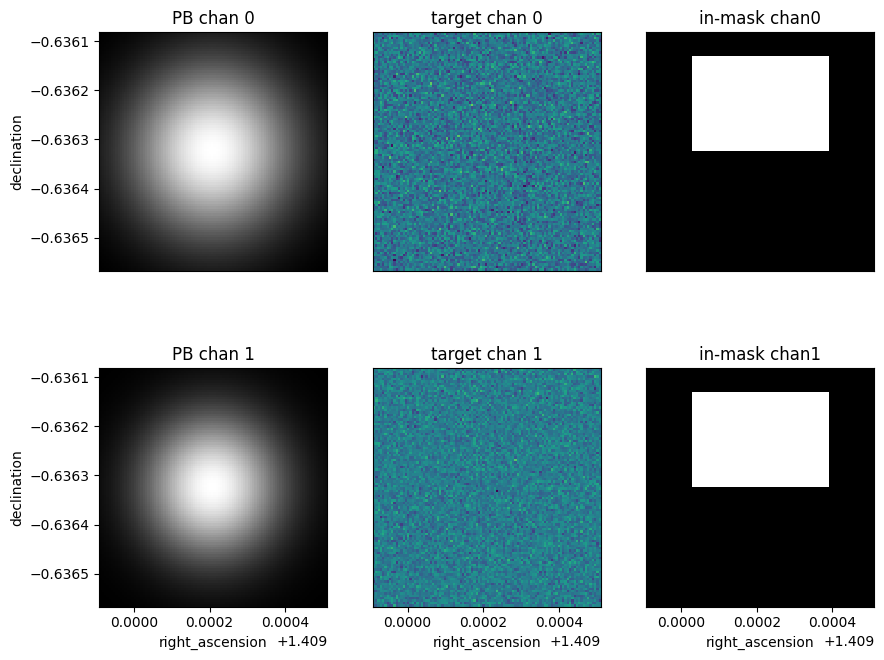

In [10]:
nchan = len(freqs)
fig, axes = plt.subplots(2,3, figsize=(10,8))
for i in range(nchan):
    data_sel = {'time':0, 'frequency':i, 'polarization':0}
    #pb_data = pb_xds.SKY.isel(data_sel).compute().squeeze()
    #target_data = target_xds.SKY.isel(data_sel).compute().squeeze()
    #inmask_data = target_xds.MASK.isel(data_sel).compute().squeeze()
    #im1 = axes[i,0].imshow(pb_data, cmap='viridis')
    pb_xds.SKY.isel(data_sel).squeeze().plot.pcolormesh(x='right_ascension', y='declination', ax=axes[i,0], cmap='grey', add_colorbar=False)
    if i==0:
        axes[0,0].xaxis.set_visible(False)
        axes[0,1].xaxis.set_visible(False)
        axes[0,2].xaxis.set_visible(False)
    axes[i,0].set_title(f'PB chan {i}')
    axes[i,0].set_aspect(1.3)
    #im2 = axes[i,1].imshow(target_data,  cmap='viridis')
    target_xds.SKY.isel(data_sel).squeeze().plot.pcolormesh(x='right_ascension',y='declination', ax=axes[i,1], cmap='viridis', add_colorbar=False)
    axes[i,1].set_title(f'target chan {i}')
    axes[i,1].yaxis.set_visible(False)
    axes[i,1].set_aspect(1.3)
    #im3 = axes[i,2].imshow(inmask_data, cmap='grey')
    target_xds.MASK.isel(data_sel).squeeze().plot.pcolormesh(x='right_ascension',y='declination',ax=axes[i,2], cmap='grey', add_colorbar=False)
    axes[i,2].set_title(f'in-mask chan{i}')
    axes[i,2].yaxis.set_visible(False)
    axes[i,2].set_aspect(1.3)
plt.show()

## Example 1: Create PB threshold based mask 


### Create the mask

In [11]:
mask_xds = make_mask(input_image=pb_xds, threshold=0.9, target_image=target_xds)

##### The mask data is stored in MASK data variable

In [12]:
mask_xds

<xarray.Dataset> Size: 182kB
Dimensions:          (time: 1, frequency: 2, polarization: 1, l: 100, m: 100)
Coordinates:
  * time             (time) float64 8B 6.095e+04
  * frequency        (frequency) float64 16B 1e+11 1.2e+11
  * polarization     (polarization) <U1 4B 'I'
  * l                (l) float64 800B 0.0002424 0.0002376 ... -0.0002376
  * m                (m) float64 800B -0.0002424 -0.0002376 ... 0.0002376
    velocity         (frequency) float64 16B 4.997e+07 0.0
    right_ascension  (l, m) float64 80kB 1.41 1.41 1.41 ... 1.409 1.409 1.409
    declination      (l, m) float64 80kB -0.6366 -0.6366 ... -0.6361 -0.6361
Data variables:
    MASK             (time, frequency, polarization, l, m) bool 20kB False .....

### Plot mask data for confirmation

In [13]:
# Extract numpy mask data
data_sel = {'time':0, 'frequency':0, 'polarization':0}
mask_data = mask_xds.MASK.isel(data_sel).compute().squeeze()

In [14]:
mask_xds.MASK.dims

('time', 'frequency', 'polarization', 'l', 'm')

In [15]:
# Number of True in the mask
np.sum(mask_data)

<xarray.DataArray 'MASK' ()> Size: 8B
array(405)
Coordinates:
    time          float64 8B 6.095e+04
    frequency     float64 8B 1e+11
    velocity      float64 8B 4.997e+07
    polarization  <U1 4B 'I'

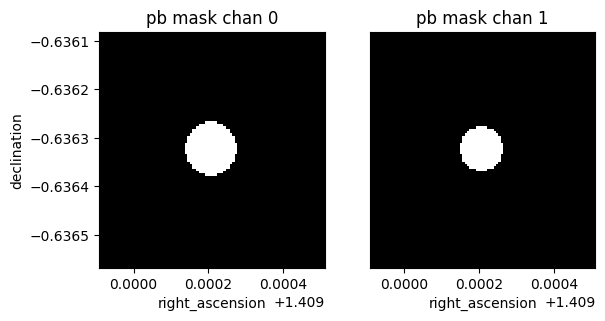

In [16]:
# input image has two channels, plot both channel's mask
fig, axes = plt.subplots(1,2)
for i in range(len(freqs)):
    data_sel = {'time':0, 'frequency':i, 'polarization':0}
    mask_xds["MASK"].isel(data_sel).squeeze().plot.pcolormesh(x='right_ascension', y='declination', ax=axes[i], cmap='grey', add_colorbar=False)
    axes[i].set_title(f'pb mask chan {i}')
    axes[i].set_aspect(1.3)
axes[-1].yaxis.set_visible(False)
plt.show()

## Example 2: Combining with the existing mask

Following is the example of combining PB-based threshold mask with existing mask in the target image. 

In [17]:
mask_xds_2 = make_mask(input_image=pb_xds, threshold=0.5, target_image=target_xds, combine_mask=True)

Found 'active_mask' attr.


### Plot the combined mask

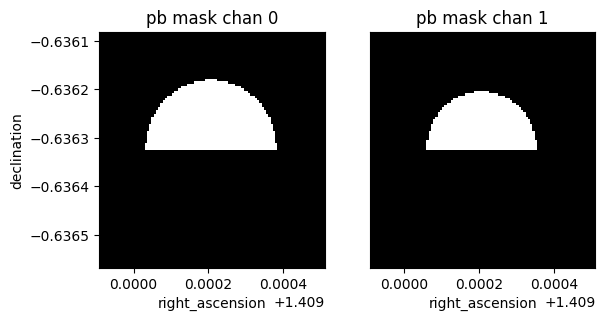

In [18]:
fig, axes = plt.subplots(1,2)
for i in range(len(freqs)):
    data_sel = {'time':0, 'frequency':i, 'polarization':0}
    mask_xds_2["MASK"].isel(data_sel).squeeze().plot.pcolormesh(x='right_ascension',y='declination',ax=axes[i], cmap='grey', add_colorbar=False)
    axes[i].set_title(f'pb mask chan {i}')
    axes[i].set_aspect(1.3)
    axes[-1].yaxis.set_visible(False)
plt.show()

## Example 3: Apply a mask to target image
Note that apply_on_target=True makes a copy of target xds image before modifying it so that 'make_mask' resturns a new xds and the original will not be modified.

In [19]:
target_with_mask_xds = make_mask(input_image=pb_xds, threshold=0.9, target_image=target_xds, apply_on_target=True)

### Verify that the returned image xds contains the original SKY with generated MASK added

In [20]:
target_with_mask_xds

<xarray.Dataset> Size: 342kB
Dimensions:            (time: 1, frequency: 2, polarization: 1, l: 100, m: 100,
                        beam_params_label: 3)
Coordinates:
  * time               (time) float64 8B 6.095e+04
  * frequency          (frequency) float64 16B 1e+11 1.2e+11
  * polarization       (polarization) <U1 4B 'I'
  * l                  (l) float64 800B 0.0002424 0.0002376 ... -0.0002376
  * m                  (m) float64 800B -0.0002424 -0.0002376 ... 0.0002376
  * beam_params_label  (beam_params_label) <U5 60B 'major' 'minor' 'pa'
    velocity           (frequency) float64 16B 4.997e+07 0.0
    right_ascension    (l, m) float64 80kB 1.41 1.41 1.41 ... 1.409 1.409 1.409
    declination        (l, m) float64 80kB -0.6366 -0.6366 ... -0.6361 -0.6361
Data variables:
    SKY                (time, frequency, polarization, l, m) float64 160kB -1...
    MASK               (time, frequency, polarization, l, m) bool 20kB False ...
Attributes:
    data_groups:             {'base': {}}
    coordinate_system_info:  {'reference_direction': {'attrs': {'frame': 'fk5...
    type:                    image

In [21]:
target_with_mask_xds["SKY"].attrs["active_mask"]

'MASK'

In [22]:
target_with_mask_xds["MASK"].values

array([[[[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]],


        [[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]]]],
      shape=(1, 2, 1, 100, 100))

#### Plot the MASK data 

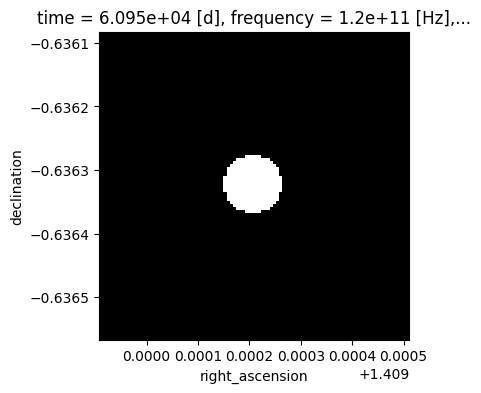

In [23]:
fig,ax = plt.subplots(figsize=(4,4))
target_with_mask_xds["MASK"].isel(data_sel).plot.pcolormesh(x='right_ascension',  y='declination', cmap='grey', add_colorbar=False)

In [24]:
target_xds

<xarray.Dataset> Size: 342kB
Dimensions:            (time: 1, frequency: 2, polarization: 1, l: 100, m: 100,
                        beam_params_label: 3)
Coordinates:
  * time               (time) float64 8B 6.095e+04
  * frequency          (frequency) float64 16B 1e+11 1.2e+11
  * polarization       (polarization) <U1 4B 'I'
  * l                  (l) float64 800B 0.0002424 0.0002376 ... -0.0002376
  * m                  (m) float64 800B -0.0002424 -0.0002376 ... 0.0002376
  * beam_params_label  (beam_params_label) <U5 60B 'major' 'minor' 'pa'
    velocity           (frequency) float64 16B 4.997e+07 0.0
    right_ascension    (l, m) float64 80kB 1.41 1.41 1.41 ... 1.409 1.409 1.409
    declination        (l, m) float64 80kB -0.6366 -0.6366 ... -0.6361 -0.6361
Data variables:
    SKY                (time, frequency, polarization, l, m) float64 160kB -1...
    MASK               (time, frequency, polarization, l, m) bool 20kB dask.array<chunksize=(1, 2, 1, 100, 100), meta=np.ndarray>
Attributes:
    data_groups:             {'base': {}}
    coordinate_system_info:  {'reference_direction': {'attrs': {'frame': 'fk5...
    type:                    image

#### Verify that the MASK data of the input target image is not modified.

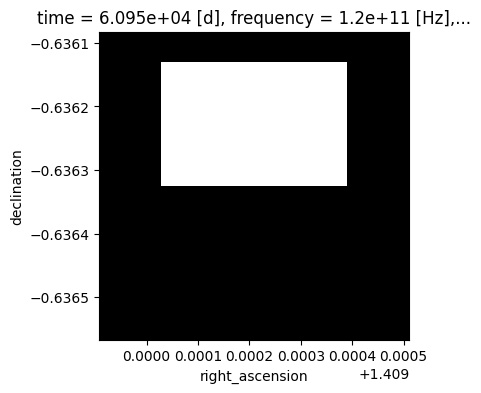

In [25]:
# original target xds mask image
fig,ax = plt.subplots(figsize=(4,4))
target_xds["MASK"].isel(data_sel).plot.pcolormesh(x='right_ascension', y='declination', cmap='grey', add_colorbar=False)